In [44]:
# import necessary libraries
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import folium 
import time, json
from datetime import datetime 
import calendar

sns.set_theme(style= 'whitegrid')


In [45]:
# Load the dataset
acled = pd.read_csv('data/kenya_demonstration_events_by_month-year_as-of-09oct2025.csv')

acled.head()
acled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  346 non-null    object
 1   Month    346 non-null    object
 2   Year     346 non-null    int64 
 3   Events   346 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 10.9+ KB


In [46]:
# Convert month names to numbers if needed
if acled['Month'].dtype == 'object':
    acled['month_num'] = acled['Month'].apply(lambda x: list(calendar.month_name).index(x))
else:
    acled['month_num'] = acled['Month']

# Create datetime column
acled['date'] = pd.to_datetime(acled['Year'].astype(str) + '-' + acled['month_num'].astype(str) + '-01')

# Sort data
acled = acled.sort_values('date')
acled.head()


,Country,Month,Year,Events,month_num,date
0,Kenya,January,1997,1,1,1997-01-01
1,Kenya,February,1997,5,2,1997-02-01
2,Kenya,March,1997,0,3,1997-03-01
3,Kenya,April,1997,2,4,1997-04-01
4,Kenya,May,1997,3,5,1997-05-01


In [47]:
election_years = [2002,2007,2013,2017, 2022]
acled['election_year'] =acled['Year'].apply(lambda x: 1 if x in election_years else 0)


In [48]:
tax_policy_events = {
    '2016-12': 'Excise Duty Act',
    '2018-09': 'VAT on Fuel',
    '2021-07': 'Finance Act',
    '2022-08': 'Fuel Subsidy Removal',
    '2023-07': 'Finance Bill 2023',
    '2024-06': 'Housing Levy Protests',
    '2025-06': 'Proposed VAT Expansion'
}

# Add a flag column
acled['tax_related'] = acled['date'].dt.strftime('%Y-%m').isin(tax_policy_events.keys()).astype(int)

acled['tax_event_name'] = acled['date'].dt.strftime('%Y-%m').map(tax_policy_events)

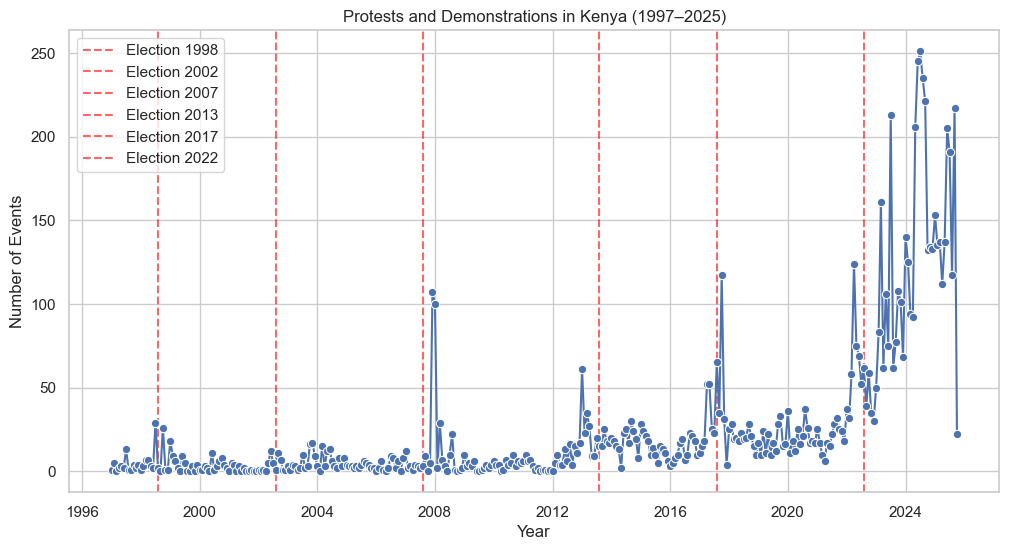

In [55]:
plt.figure(figsize=(12,6))
for year in [1998,2002, 2007, 2013, 2017, 2022]:
    plt.axvline(pd.to_datetime(f"{year}-08-01"), color='red', linestyle='--', alpha=0.6, label=f"Election {year}")
sns.lineplot(data=acled, x='date', y='Events', marker='o')
plt.title("Protests and Demonstrations in Kenya (1997–2025)")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.grid(True)
plt.show()


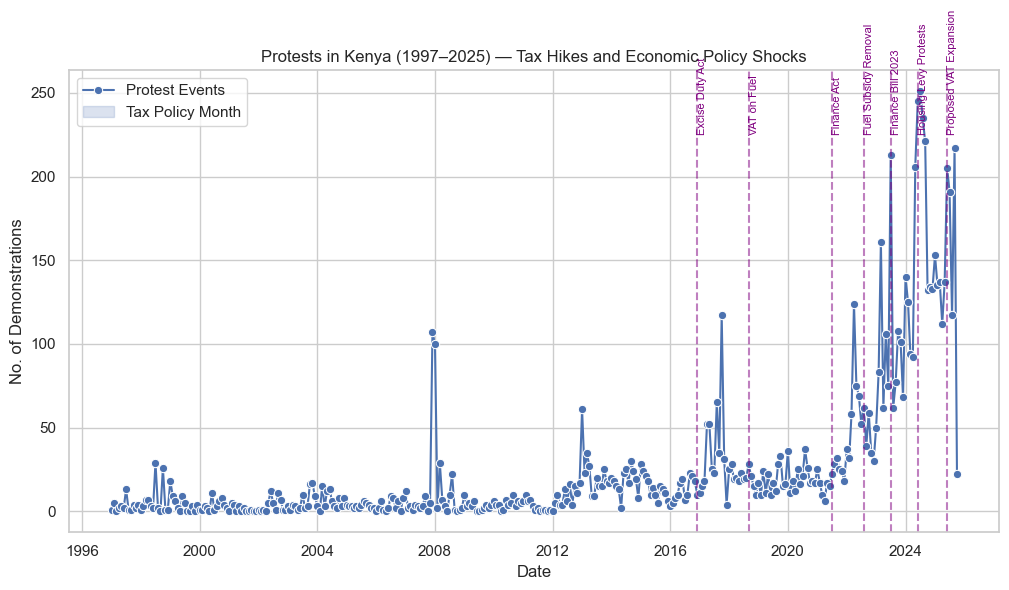

In [50]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='Events', data=acled, marker='o', label='Protest Events')

# Highlight tax policy months
for date_str, event in tax_policy_events.items():
    plt.axvline(pd.to_datetime(date_str), color='purple', linestyle='--', alpha=0.5)
    plt.text(pd.to_datetime(date_str), acled['Events'].max()*0.9, event, rotation=90, color='purple', fontsize=8)

plt.title("Protests in Kenya (1997–2025) — Tax Hikes and Economic Policy Shocks")
plt.xlabel("Date")
plt.ylabel("No. of Demonstrations")
plt.legend(['Protest Events', 'Tax Policy Month'])
plt.grid(True)
plt.show()

C:\Users\HomePC\AppData\Local\Temp\ipykernel_47148\2364024255.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='tax_period', y='Events', palette='Purples')


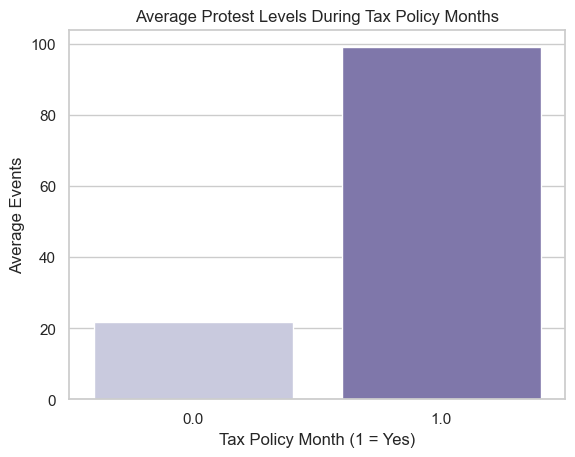

In [51]:
acled['tax_period'] = acled['tax_related'].rolling(window=2, center=True).max()  # includes month before/after

summary = acled.groupby('tax_period')['Events'].mean().reset_index()
sns.barplot(data=summary, x='tax_period', y='Events', palette='Purples')
plt.title("Average Protest Levels During Tax Policy Months")
plt.xlabel("Tax Policy Month (1 = Yes)")
plt.ylabel("Average Events")
plt.show()


C:\Users\HomePC\AppData\Local\Temp\ipykernel_47148\3072115023.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Events', data=annual, palette='coolwarm')


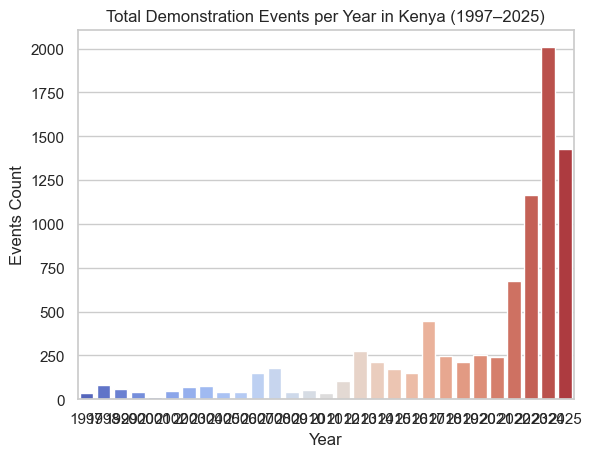

In [52]:
annual = acled.groupby('Year')['Events'].sum().reset_index()

sns.barplot(x='Year', y='Events', data=annual, palette='coolwarm')
plt.title("Total Demonstration Events per Year in Kenya (1997–2025)")
plt.ylabel("Events Count")
plt.show()


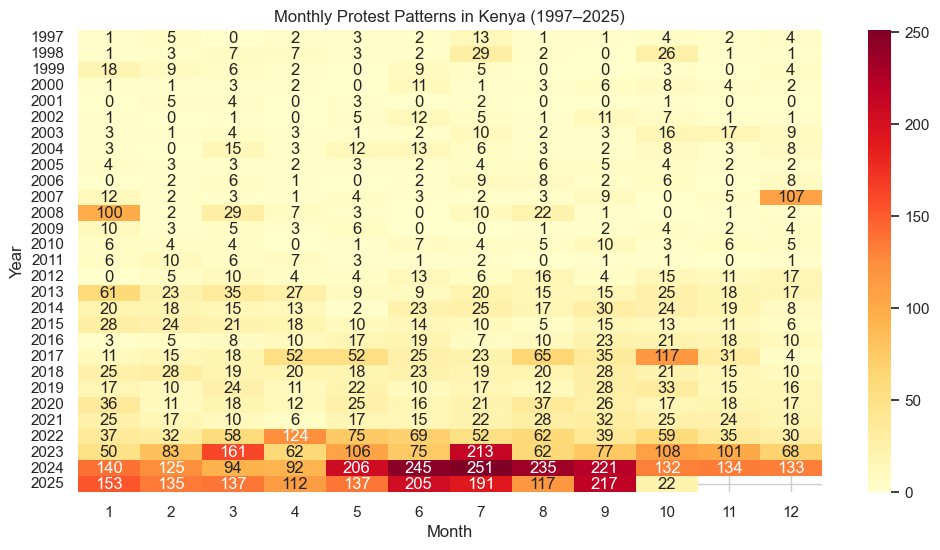

In [53]:
pivot = acled.pivot_table(values='Events', index='Year', columns='month_num', aggfunc='sum')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='g')
plt.title("Monthly Protest Patterns in Kenya (1997–2025)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


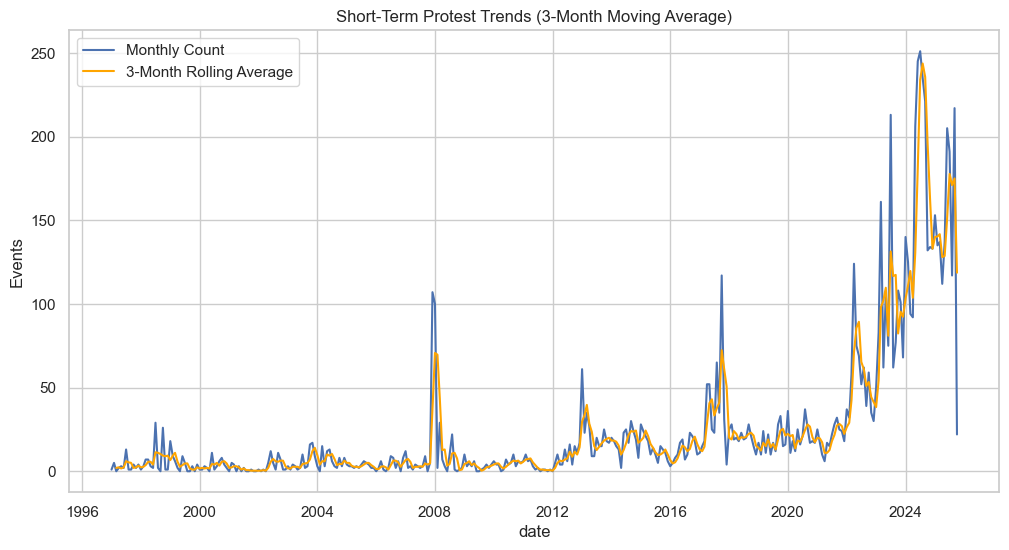

In [54]:
acled['rolling_avg'] = acled['Events'].rolling(window=3).mean()

plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='Events', data=acled, label='Monthly Count')
sns.lineplot(x='date', y='rolling_avg', data=acled, label='3-Month Rolling Average', color='orange')
plt.title("Short-Term Protest Trends (3-Month Moving Average)")
plt.legend()
plt.show()
